# Setup

In [1]:
import pandas as pd
import time
import json
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from IPython.display import clear_output, display

import torch
import torchfile
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.serialization import load_lua

from PIL import Image
import argparse
import cv2

# Image2Gray

In [ ]:
def make_gray_img(img_paths):
    # Output 디렉토리 만들기
    if not os.path.exists('./gray'):  # 디렉토리가 없으면
        os.makedirs('./gray')
        print('Successfully created the gray directory.')
    else:
        print('The gray directory already exists.') # 디렉토리가 있으면
    
    # img_paths가 단일 경로(str)인 경우
    if isinstance(img_paths, str):
        img_paths = [img_paths]  # 단일 경로를 리스트로 변환
        
    img_paths = [img_path.replace('\\', '/') for img_path in img_paths]  # 슬래시 통일
    img_paths = sorted(img_paths, key=lambda x: int(x.split('/')[-1].split('.')[0]))  # 이미지 경로/{index}.jpg인 경우 정렬
    for img_path in img_paths:
        name = img_path.split('/')[-1].split('.')[0] # 이미지 경로/{이름}.jpg인 경우에 이름만 출력
        img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
        if img is None:
            print("Error: {} not found.".format(img_path))

        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_invert = cv2.bitwise_not(gray_image)
        img_smoothing = cv2.GaussianBlur(img_invert, (21, 21), sigmaX=0, sigmaY=0)
        final_img = cv2.divide(gray_image, 255 - img_smoothing, scale=256)
        
        if os.path.exists('./gray/{}.jpg'.format(name)):  # gray 디렉토리에 이미지가 이미 존재하면 저장안함.
            print("{}.jpg is alreay exists.".format(name))
        else:
            cv2.imwrite('./gray/{}.jpg'.format(name), final_img)
            print("Saved image to: ./gray/{}.jpg".format(name)) 

    return final_img

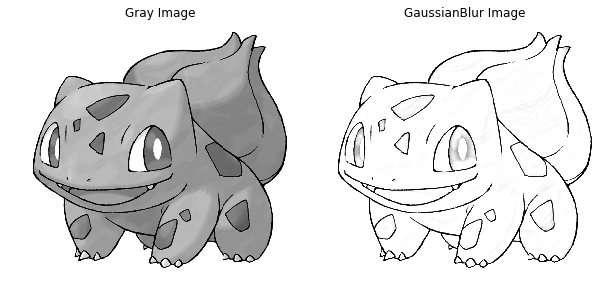

In [4]:
#make gray img
img = cv2.imread('./images/0.jpg')
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# not 연산 반대로
img_invert = cv2.bitwise_not(gray_image)

# 가우시안 블러 적용
# src: 적용 대상,
# ksize: 가우시안 커널 크기. (0, 0)을 지정하면 sigma 값에 의해 자동 결정됨 - 
# 숫자가 작으면 선이 유실되고,
# 숫자가 많으면 선이 너무 찐하게 나와서 적정값이 21
img_smoothing = cv2.GaussianBlur(img_invert, (21, 21), sigmaX=0, sigmaY=0)

# gray_image 에서 255 - img_smoothing를 나누기 연산
final_img = cv2.divide(gray_image, 255 - img_smoothing, scale=256)

cv2.imwrite('./gray.jpg',final_img)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title('Gray Image')
plt.axis('off')
plt.imshow(gray_image,cmap='gray')
plt.subplot(1,2,2)
plt.title('GaussianBlur Image')
plt.axis('off')
plt.imshow(final_img,cmap='gray')

plt.show()

# Download Model

In [ ]:
import hashlib
import os
import requests

def download_model(model_name, filename, file_url, file_md5):
#     print(f"Downloading the sketch simplification {model_name} model...")
    print("Downloading the sketch simplification {} model...".format(model_name))


    # 파일 다운로드
    response = requests.get(file_url, stream=True)
    response.raise_for_status()  # 다운로드가 실패한 경우 예외 발생

    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192): 
            file.write(chunk)

    # MD5 체크섬 확인
    print("Checking integrity (md5sum)...")
    checksum = calculate_md5(filename)

    if checksum != file_md5:
        print("failed")
        print("Integrity check failed. File is corrupt!")
#         print(f"Try running this script again and if it fails remove '{filename}' before trying again.")
        print("Try running this script again and if it fails remove '{}' before trying again.".format(filename))
        raise ValueError("File integrity check failed.")

    print("ok")

def calculate_md5(filename):
    hash_md5 = hashlib.md5()
    with open(filename, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# 모델 다운로드
def select_model (model_name):
    if model_name == 'MSE':
        download_model("MSE", "model_mse.t7", "https://esslab.jp/~ess/data/sketch_mse.t7", "12317df9a0a2a7220629f5f361b45b82")
    elif model_name == 'GAN':
        download_model("GAN", "model_gan.t7", "https://esslab.jp/~ess/data/sketch_gan.t7", "3a5b4088f2490ca4b8140a374e80c878")
    elif model_name == 'PENCIL(1)':
        download_model("PENCIL(1)", "model_pencil1.t7", "https://esslab.jp/~ess/data/pencil_artist1.t7", "33d553ff3a50d6522e79a73002b0025c")
    elif model_name == 'PENCIL(2)':
        download_model("PENCIL(2)", "model_pencil2.t7", "https://esslab.jp/~ess/data/pencil_artist2.t7", "537b3ad9d46b2a82b65883be747a7ba9")

    print("Downloads finished successfully!")

In [ ]:
# select_model('MSE')
select_model('GAN')
# select_model('PENCIL(1)')
# select_model('PENCIL(2)')

# Gray2Sketch

In [ ]:
def make_pencil_img(gray_img_paths,model):
    use_cuda = torch.cuda.device_count() > 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cache  = load_lua(model,long_size=8)
    # cache = torchfile.load('./model_gan.t7')
    model  = cache.model
    immean = cache.mean
    imstd  = cache.std
    model.evaluate()
    
    # Ouput 디렉토리 만들기
    if not os.path.exists('./sketch'):  # 디렉토리가 없으면
        os.makedirs('./sketch')
        print('Successfully created the sketch directory.')
    else: # 디렉토리가 있으면
        print('The sketch directory already exists.')
        
    # gray_img_paths가 단일 경로(str)인 경우
    if isinstance(gray_img_paths, str):
        gray_img_paths = [gray_img_paths]  # 단일 경로를 리스트로 변환
    
    gray_img_paths = [gray_img_path.replace('\\', '/') for gray_img_path in gray_img_paths]  # 슬래시 통일    
    gray_img_paths = sorted(gray_img_paths, key=lambda x: int(x.split('/')[-1].split('.')[0]))  # 파일명 기준 정렬
    for gray_img_path in gray_img_paths:
        gray_img_path = gray_img_path.replace('\\','/')
        name = gray_img_path.split('/')[-1].split('.')[0]
        data = Image.open(gray_img_path).convert('L')

        w, h = data.size[0], data.size[1]
        pw = 8-(w%8) if w%8!=0 else 0
        ph = 8-(h%8) if h%8!=0 else 0

        print('start unsqueeze()')

        data = ((transforms.ToTensor()(data)-immean)/imstd).unsqueeze(0)
        if pw != 0 or ph != 0:
            data = torch.nn.ReplicationPad2d( (0,pw,0,ph) )( data ).data

        print('start ReplicationPad2d()')
        if use_cuda:
            print(' use cuda')
            pred = model.cuda().forward(data.cuda()).float()
        else:
            print('don\'t use cuda')
            pred = model.forward(data)
        
        if os.path.exists('./sketch/{}.jpg'.format(name)):
            print("{}.jpg is alreay exists.".format(name))
        else:
            save_image(pred[0], './sketch/{}.jpg'.format(name))
            print("Saved image to: ./sketch/{}.jpg".format(name)) 

start unsqueeze()
start ReplicationPad2d()
don't use cuda


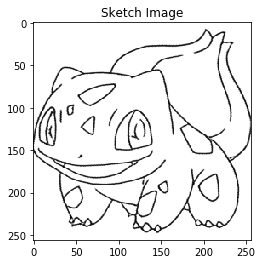

In [5]:
use_cuda = torch.cuda.device_count() > 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cache  = load_lua('./model_gan.t7',long_size=8)
model  = cache.model
immean = cache.mean
imstd  = cache.std
model.evaluate()

data = Image.open('./gray.jpg').convert('L')

w, h = data.size[0], data.size[1]
pw = 8-(w%8) if w%8!=0 else 0
ph = 8-(h%8) if h%8!=0 else 0

print('start unsqueeze()')

data = ((transforms.ToTensor()(data)-immean)/imstd).unsqueeze(0)
if pw != 0 or ph != 0:
    data = torch.nn.ReplicationPad2d( (0,pw,0,ph) )( data ).data

print('start ReplicationPad2d()')
if use_cuda:
    print(' use cuda')
    pred = model.cuda().forward(data.cuda()).float()
else:
    print('don\'t use cuda')
    pred = model.forward(data)

sketch_img = pred[0].squeeze(0).numpy()
plt.title('Sketch Image')
plt.imshow(sketch_img,cmap='gray')